# Улучшение модели предсказания зарплаты с помощью NLP

## Введение

**Помните задачу из первого дня?** Мы предсказывали зарплату по вакансиям с hh.ru, но тогда **пришлось удалить все текстовые признаки** (название вакансии, описание), потому что мы еще не знали, как работать с текстом!

### Что было в первый день:

- ❌ Удалили `name_clean` (название вакансии)
- ❌ Удалили `raw_description` (описание вакансии)
- ❌ Удалили `employer_name` (название компании)
- ✅ Использовали только числовые и категориальные признаки
- 📊 Лучший результат: **Test MAE ≈ 16,283 ₽**, **R² ≈ 0.33**

### Что будем делать сегодня:

Теперь, когда мы знаем NLP, давайте **добавим текстовые признаки** и посмотрим на улучшение качества!

Мы попробуем два подхода:
1. **CountVectorizer (Bag of Words)** — простой подсчет слов
2. **Sentence Transformers** — современные эмбеддинги на основе нейросетей

Будем использовать **название вакансии** (`name_clean`) — это короткий текст, который хорошо характеризует позицию.

### План работы:

1. Загрузим данные и посмотрим на примеры
2. Воспроизведем baseline (без текста) для сравнения
3. Добавим текстовые признаки через CountVectorizer
4. Добавим текстовые признаки через Sentence Transformers
5. Сравним все подходы и посмотрим на улучшения!


## 1. Загрузка и подготовка данных


In [1]:
# Импорты
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# Для воспроизводимости результатов
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


### Загрузка данных

Используем те же данные, что и в первый день.


In [2]:
# ! gdown --fuzzy "https://drive.google.com/file/d/1MQwhsmim8FUh0s8lwb63TEDWUMcH9xZT/view?usp=sharing"
# ! unzip -q vacancy.zip

In [3]:
# Загружаем данные (убедитесь, что файлы находятся в папке day_1/)
train_df = pd.read_csv("train_split.tsv", sep="\t")
test_df = pd.read_csv("test_split.tsv", sep="\t")

print(f"Train размер: {train_df.shape}")
print(f"Test размер: {test_df.shape}")
print("\nКолонки в датасете:")
print(train_df.columns.tolist())


Train размер: (49051, 28)
Test размер: (12263, 28)

Колонки в датасете:
['id', 'name', 'employer_name', 'experience_name', 'schedule_name', 'key_skills_name', 'accept_handicapped', 'accept_kids', 'unified_address_city', 'unified_address_state', 'unified_address_region', 'unified_address_country', 'specializations_profarea_name', 'professional_roles_name', 'languages_name', 'raw_description', 'raw_branded_description', 'lemmaized_wo_stopwords_raw_description', 'lemmaized_wo_stopwords_raw_branded_description', 'if_foreign_language', 'is_branded_description', 'name_clean', 'employment_name', 'employer_id', 'employer_industries', 'salary_mean_net', 'lemmaized_wo_stopwords_raw_description_salaries', 'lemmaized_wo_stopwords_raw_branded_description_salaries']


### Посмотрим на примеры названий вакансий

Это тот самый текстовый признак, который мы будем использовать!


In [4]:
# Примеры названий вакансий и их зарплаты
print("Примеры вакансий:\n")
examples = train_df[['name_clean', 'salary_mean_net']].dropna().sample(10, random_state=42)
for idx, row in examples.iterrows():
    print(f"💼 {row['name_clean']}")
    print(f"   💰 {row['salary_mean_net']:,.0f} ₽\n")


Примеры вакансий:

💼 специалист отдел маркетинг реклама
   💰 25,000 ₽

💼 администратор менеджер
   💰 80,000 ₽

💼 торговый представитель общий ассортимент продукт питание
   💰 70,000 ₽

💼 помощник системный администратор
   💰 37,500 ₽

💼 инженер проектировщик автомобильный дорога
   💰 21,750 ₽

💼 разнорабочий литейный цех
   💰 82,000 ₽

💼 инженер технический поддержка выездной инженер
   💰 62,205 ₽

💼 отделочник универсал
   💰 105,000 ₽

💼 продавец консультант
   💰 25,334 ₽

💼 мастер прораб смр
   💰 65,250 ₽



### Базовая статистика по текстовым данным


In [5]:
# Статистика по названиям вакансий
print("Статистика по полю name_clean:\n")
print(f"Всего записей: {len(train_df)}")
print(f"Заполнено: {train_df['name_clean'].notna().sum()}")
print(f"Пропущено: {train_df['name_clean'].isna().sum()}")
print(f"Уникальных названий: {train_df['name_clean'].nunique()}")

# Средняя длина названия
length = train_df['name_clean'].fillna('').str.len()
print(f"\nСредняя длина названия: {length.mean():.1f} символов")
print(f"Медианная длина: {length.median():.0f} символов")
print(f"Максимальная длина: {length.max():.0f} символов")


Статистика по полю name_clean:

Всего записей: 49051
Заполнено: 49051
Пропущено: 0
Уникальных названий: 23319

Средняя длина названия: 27.8 символов
Медианная длина: 25 символов
Максимальная длина: 97 символов


## 2. Baseline модель (без текстовых признаков)

Сначала воспроизведем результат из первого дня — обучим модель **БЕЗ** текстовых признаков.
Это наш baseline для сравнения.


### Предобработка данных (как в первый день)


In [6]:
def prepare_features_no_text(df, is_train=True):
    """
    Подготовка признаков БЕЗ текстовых полей (как в первый день)
    """
    df = df.copy()
    
    # Удаляем текстовые колонки (как делали в первый день)
    text_cols = ['raw_description', 'raw_branded_description', 
                 'lemmaized_wo_stopwords_raw_description',
                 'lemmaized_wo_stopwords_raw_branded_description',
                 'lemmaized_wo_stopwords_raw_description_salaries',
                 'lemmaized_wo_stopwords_raw_branded_description_salaries',
                 'name_clean', 'employer_name', 'name']
    
    df = df.drop(columns=[col for col in text_cols if col in df.columns], errors='ignore')
    
    # Удаляем служебные и целевую переменную
    cols_to_drop = ['id', 'salary_mean_net']
    X = df.drop(columns=[col for col in cols_to_drop if col in df.columns], errors='ignore')
    
    # Преобразуем категориальные признаки в числовые (простой label encoding)
    categorical_cols = X.select_dtypes(include=['object', 'bool']).columns
    
    for col in categorical_cols:
        if X[col].dtype == 'object':
            X[col] = X[col].astype('category').cat.codes
        else:
            X[col] = X[col].astype(int)
    
    # Заполняем пропуски медианой
    X = X.fillna(X.median())
    
    return X


In [7]:
# Подготовка данных для baseline
X_train_baseline = prepare_features_no_text(train_df, is_train=True)
y_train = train_df['salary_mean_net'].values

X_test_baseline = prepare_features_no_text(test_df, is_train=False)
y_test = test_df['salary_mean_net'].values

print(f"X_train_baseline shape: {X_train_baseline.shape}")
print(f"X_test_baseline shape: {X_test_baseline.shape}")
print(f"Количество признаков (БЕЗ текста): {X_train_baseline.shape[1]}")


X_train_baseline shape: (49051, 17)
X_test_baseline shape: (12263, 17)
Количество признаков (БЕЗ текста): 17


### Обучение baseline модели


In [8]:
# Используем Ridge регрессию (быстрая и стабильная)
baseline_model = LassoCV(alphas=[0.001, 0.01, 0.1, 1, 10, 100, 1000], random_state=RANDOM_STATE)
baseline_model.fit(X_train_baseline, y_train)

# Предсказания
y_pred_baseline = baseline_model.predict(X_test_baseline)

# Метрики
baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
baseline_r2 = r2_score(y_test, y_pred_baseline)

print("="*60)
print("BASELINE (БЕЗ текстовых признаков)")
print("="*60)
print(f"Test MAE:  {baseline_mae:,.2f} ₽")
print(f"Test RMSE: {baseline_rmse:,.2f} ₽")
print(f"Test R²:   {baseline_r2:.4f}")
print("="*60)

# Сохраняем результаты для сравнения
results = {
    'Baseline (без текста)': {
        'MAE': baseline_mae,
        'RMSE': baseline_rmse,
        'R²': baseline_r2,
        'predictions': y_pred_baseline
    }
}


BASELINE (БЕЗ текстовых признаков)
Test MAE:  23,906.88 ₽
Test RMSE: 29,293.74 ₽
Test R²:   0.0402


## 3. Подход 1: CountVectorizer (Bag of Words)

### Теория: Что такое Bag of Words?

**Bag of Words (мешок слов)** — это простой способ превратить текст в числа:

1. Берем все уникальные слова из всех документов → **словарь**
2. Для каждого документа считаем, сколько раз встречается каждое слово
3. Получаем вектор чисел для каждого документа

**Пример:**
```
Документ 1: "Python разработчик"
Документ 2: "Java разработчик"
Документ 3: "Python программист"

Словарь: [python, java, разработчик, программист]

Векторы:
Документ 1: [1, 0, 1, 0]  # есть python, есть разработчик
Документ 2: [0, 1, 1, 0]  # есть java, есть разработчик
Документ 3: [1, 0, 0, 1]  # есть python, есть программист
```

**CountVectorizer** из sklearn делает это автоматически!

### Важные параметры:
- `max_features` — ограничить количество слов (брать самые частые)
- `min_df` — минимальная частота слова (игнорировать редкие слова)
- `max_df` — максимальная частота (игнорировать слишком частые слова)
- `ngram_range` — использовать не только отдельные слова, но и пары/тройки


### TODO: Ваша задача — применить CountVectorizer

Заполните пропущенные места в коде ниже:


In [9]:
# TODO 1: Заполняем пропуски в названиях вакансий пустой строкой
train_texts = train_df['name_clean'].fillna('').values
test_texts = test_df['name_clean'].fillna('').values

print("Примеры текстов для векторизации:")
for i in range(5):
    print(f"  {i+1}. {train_texts[i]}")


Примеры текстов для векторизации:
  1. менеджер продажа семя сзр биопрепарат региональный представитель
  2. врач патологоанатом отделение общий патология патологоанатомический бюро
  3. инженер отдел материально технический обеспечение
  4. начальник ювелирный производство
  5. инженер технолог 3 категория


In [10]:
# TODO 2: Инициализируйте CountVectorizer с параметрами
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=3000)

print("✓ CountVectorizer создан" if vectorizer is not None else "TODO: создайте vectorizer")


✓ CountVectorizer создан


In [11]:
# TODO 3: Примените fit_transform на train и transform на test

X_train_text = vectorizer.fit_transform(train_texts)
X_test_text = vectorizer.transform(test_texts)

print(f"X_train_text shape: {X_train_text.shape if X_train_text is not None else 'TODO'}")
print(f"X_test_text shape: {X_test_text.shape if X_test_text is not None else 'TODO'}")
if vectorizer is not None and hasattr(vectorizer, 'vocabulary_'):
    print(f"Размер словаря: {len(vectorizer.vocabulary_)}")
else:
    print("Размер словаря: TODO")


X_train_text shape: (49051, 3000)
X_test_text shape: (12263, 3000)
Размер словаря: 3000


### Посмотрим на самые частые слова в названиях вакансий


In [12]:
# Показываем топ-20 самых частых слов
if vectorizer is not None and hasattr(vectorizer, 'vocabulary_') and X_train_text is not None:
    word_counts = X_train_text.sum(axis=0).A1
    words = vectorizer.get_feature_names_out()
    top_words = sorted(zip(words, word_counts), key=lambda x: x[1], reverse=True)[:20]
    
    print("Топ-20 самых частых слов в названиях вакансий:\n")
    for word, count in top_words:
        print(f"  {word:20s} : {int(count):5d} раз")
else:
    print("TODO: сначала создайте и примените vectorizer")


Топ-20 самых частых слов в названиях вакансий:

  менеджер             :  6813 раз
  продавец             :  3530 раз
  продажа              :  3362 раз
  специалист           :  3161 раз
  врач                 :  2564 раз
  водитель             :  2526 раз
  инженер              :  2396 раз
  консультант          :  2028 раз
  отдел                :  1930 раз
  работа               :  1835 раз
  кассир               :  1761 раз
  администратор        :  1709 раз
  оператор             :  1658 раз
  магазин              :  1433 раз
  бухгалтер            :  1347 раз
  клиент               :  1187 раз
  медицинский          :  1125 раз
  руководитель         :  1039 раз
  кладовщик            :   925 раз
  автомобиль           :   889 раз


In [13]:
# TODO 4: Объедините текстовые признаки с числовыми
from scipy.sparse import hstack

X_train_combined = hstack([X_train_baseline, X_train_text])
X_test_combined = hstack([X_test_baseline, X_test_text])

print(f"X_train_combined shape: {X_train_combined.shape if X_train_combined is not None else 'TODO'}")
print(f"X_test_combined shape: {X_test_combined.shape if X_test_combined is not None else 'TODO'}")
if X_train_text is not None:
    print(f"\nДобавлено текстовых признаков: {X_train_text.shape[1]}")
else:
    print("\nДобавлено текстовых признаков: TODO")


X_train_combined shape: (49051, 3017)
X_test_combined shape: (12263, 3017)

Добавлено текстовых признаков: 3000


### Обучение модели с текстовыми признаками


In [14]:
# TODO 5: Обучите модель на данных с текстовыми признаками
if X_train_combined is not None:
    model_cv = LassoCV(alphas=[0.001, 0.01, 0.1, 1, 10, 100, 1000], random_state=RANDOM_STATE, n_jobs=8)
    model_cv.fit(X_train_combined, y_train)
    
    # Предсказания
    y_pred_cv = model_cv.predict(X_test_combined)
    
    # Метрики
    cv_mae = mean_absolute_error(y_test, y_pred_cv)
    cv_rmse = np.sqrt(mean_squared_error(y_test, y_pred_cv))
    cv_r2 = r2_score(y_test, y_pred_cv)
    
    print("="*60)
    print("МОДЕЛЬ С COUNTVECTORIZER")
    print("="*60)
    print(f"Test MAE:  {cv_mae:,.2f} ₽")
    print(f"Test RMSE: {cv_rmse:,.2f} ₽")
    print(f"Test R²:   {cv_r2:.4f}")
    print("="*60)
    
    # Улучшение по сравнению с baseline
    mae_improvement = baseline_mae - cv_mae
    r2_improvement = cv_r2 - baseline_r2
    
    print("\n📈 Улучшение:")
    print(f"   MAE: {mae_improvement:+,.2f} ₽ ({mae_improvement/baseline_mae*100:+.2f}%)")
    print(f"   R²:  {r2_improvement:+.4f} ({r2_improvement/baseline_r2*100:+.2f}%)")
    
    # Сохраняем результаты
    results['CountVectorizer'] = {
        'MAE': cv_mae,
        'RMSE': cv_rmse,
        'R²': cv_r2,
        'predictions': y_pred_cv
    }
else:
    print("TODO: сначала объедините признаки")


МОДЕЛЬ С COUNTVECTORIZER
Test MAE:  18,205.99 ₽
Test RMSE: 23,681.03 ₽
Test R²:   0.3727

📈 Улучшение:
   MAE: +5,700.89 ₽ (+23.85%)
   R²:  +0.3326 (+828.26%)


## 4. Подход 2: Sentence Transformers (Эмбеддинги)

### Теория: Что такое эмбеддинги?

**Эмбеддинги** — это плотные векторные представления текста, полученные с помощью нейросетей.

**Отличия от Bag of Words:**

| Характеристика | Bag of Words | Эмбеддинги |
|----------------|--------------|------------|
| Размер вектора | Огромный (размер словаря) | Компактный (обычно 384-768) |
| Разреженность | Очень разреженный | Плотный |
| Семантика | Нет (только подсчет) | Да (учитывает смысл) |
| Синонимы | Разные слова | Похожие векторы |
| Порядок слов | Не учитывается | Учитывается |

**Пример:**
```
"Python разработчик" и "Python developer" будут:
- В BoW: совершенно разные (разные слова)
- В эмбеддингах: очень похожие (похожий смысл)
```

**Sentence Transformers** — это библиотека, которая позволяет легко получать качественные эмбеддинги.


### TODO: Ваша задача — получить эмбеддинги с помощью Sentence Transformers


In [15]:
from sentence_transformers import SentenceTransformer

# TODO 6: Загрузите предобученную модель

sentence_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

print("✓ Модель загружена" if sentence_model is not None else "TODO: загрузите модель")


✓ Модель загружена


In [16]:
# TODO 7: Получите эмбеддинги для названий вакансий

train_embeddings = sentence_model.encode(train_texts, batch_size=32)
test_embeddings = sentence_model.encode(test_texts, batch_size=32)

print(f"train_embeddings shape: {train_embeddings.shape if train_embeddings is not None else 'TODO'}")
print(f"test_embeddings shape: {test_embeddings.shape if test_embeddings is not None else 'TODO'}")
if train_embeddings is not None:
    print(f"Размерность эмбеддингов: {train_embeddings.shape[1]}")
else:
    print("Размерность эмбеддингов: TODO")


train_embeddings shape: (49051, 384)
test_embeddings shape: (12263, 384)
Размерность эмбеддингов: 384


### Посмотрим на пример эмбеддингов


In [17]:
if train_embeddings is not None:
    print("Пример эмбеддинга для первой вакансии:")
    print(f"\nВакансия: {train_texts[0]}")
    print("\nЭмбеддинг (первые 10 значений):")
    print(train_embeddings[0][:10])
    print(f"\n...всего {len(train_embeddings[0])} чисел")
else:
    print("TODO: сначала получите эмбеддинги")


Пример эмбеддинга для первой вакансии:

Вакансия: менеджер продажа семя сзр биопрепарат региональный представитель

Эмбеддинг (первые 10 значений):
[-0.01165669  0.0545929  -0.02208661 -0.00756855 -0.07435886  0.06020692
  0.08709457  0.04628145 -0.03713556  0.02692343]

...всего 384 чисел


In [25]:
# TODO 8: Объедините эмбеддинги с числовыми признаками

X_train_with_emb = np.hstack([X_train_baseline, train_embeddings])
X_test_with_emb = np.hstack([X_test_baseline, test_embeddings])

print(f"X_train_with_emb shape: {X_train_with_emb.shape if X_train_with_emb is not None else 'TODO'}")
print(f"X_test_with_emb shape: {X_test_with_emb.shape if X_test_with_emb is not None else 'TODO'}")
if train_embeddings is not None:
    print(f"\nДобавлено признаков из эмбеддингов: {train_embeddings.shape[1]}")
else:
    print("\nДобавлено признаков из эмбеддингов: TODO")


X_train_with_emb shape: (49051, 401)
X_test_with_emb shape: (12263, 401)

Добавлено признаков из эмбеддингов: 384


In [26]:
# TODO 9: Обучите модель на данных с эмбеддингами
if X_train_with_emb is not None:
    model_emb = LassoCV(alphas=[0.001, 0.01, 0.1, 1, 10, 100, 1000], random_state=RANDOM_STATE)
    model_emb.fit(X_train_with_emb, y_train)
    
    # Предсказания
    y_pred_emb = model_emb.predict(X_test_with_emb)
    
    # Метрики
    emb_mae = mean_absolute_error(y_test, y_pred_emb)
    emb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_emb))
    emb_r2 = r2_score(y_test, y_pred_emb)
    
    print("="*60)
    print("МОДЕЛЬ С SENTENCE TRANSFORMERS")
    print("="*60)
    print(f"Test MAE:  {emb_mae:,.2f} ₽")
    print(f"Test RMSE: {emb_rmse:,.2f} ₽")
    print(f"Test R²:   {emb_r2:.4f}")
    print("="*60)
    
    # Улучшение по сравнению с baseline
    mae_improvement = baseline_mae - emb_mae
    r2_improvement = emb_r2 - baseline_r2
    
    print("\n📈 Улучшение:")
    print(f"   MAE: {mae_improvement:+,.2f} ₽ ({mae_improvement/baseline_mae*100:+.2f}%)")
    print(f"   R²:  {r2_improvement:+.4f} ({r2_improvement/baseline_r2*100:+.2f}%)")
    
    # Сохраняем результаты
    results['Sentence Transformers'] = {
        'MAE': emb_mae,
        'RMSE': emb_rmse,
        'R²': emb_r2,
        'predictions': y_pred_emb
    }
else:
    print("TODO: сначала объедините признаки")


МОДЕЛЬ С SENTENCE TRANSFORMERS
Test MAE:  20,592.09 ₽
Test RMSE: 26,073.46 ₽
Test R²:   0.2396

📈 Улучшение:
   MAE: +3,314.79 ₽ (+13.87%)
   R²:  +0.1994 (+496.67%)


## 5. Сравнение всех подходов

Теперь давайте посмотрим на итоговые результаты и визуализируем улучшения!


### Таблица с результатами


In [27]:
# Создаем таблицу результатов
results_df = pd.DataFrame([
    {'Подход': name, 'MAE (₽)': data['MAE'], 'RMSE (₽)': data['RMSE'], 'R²': data['R²']}
    for name, data in results.items()
])

# Сортируем по MAE (меньше = лучше)
results_df = results_df.sort_values('MAE (₽)')

print("\n" + "="*70)
print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)



ИТОГОВЫЕ РЕЗУЛЬТАТЫ
               Подход      MAE (₽)     RMSE (₽)       R²
      CountVectorizer 18205.987363 23681.025347 0.372732
Sentence Transformers 20592.090775 26073.460613 0.239587
Baseline (без текста) 23906.881889 29293.738321 0.040154


### Визуализация 1: Сравнение метрик


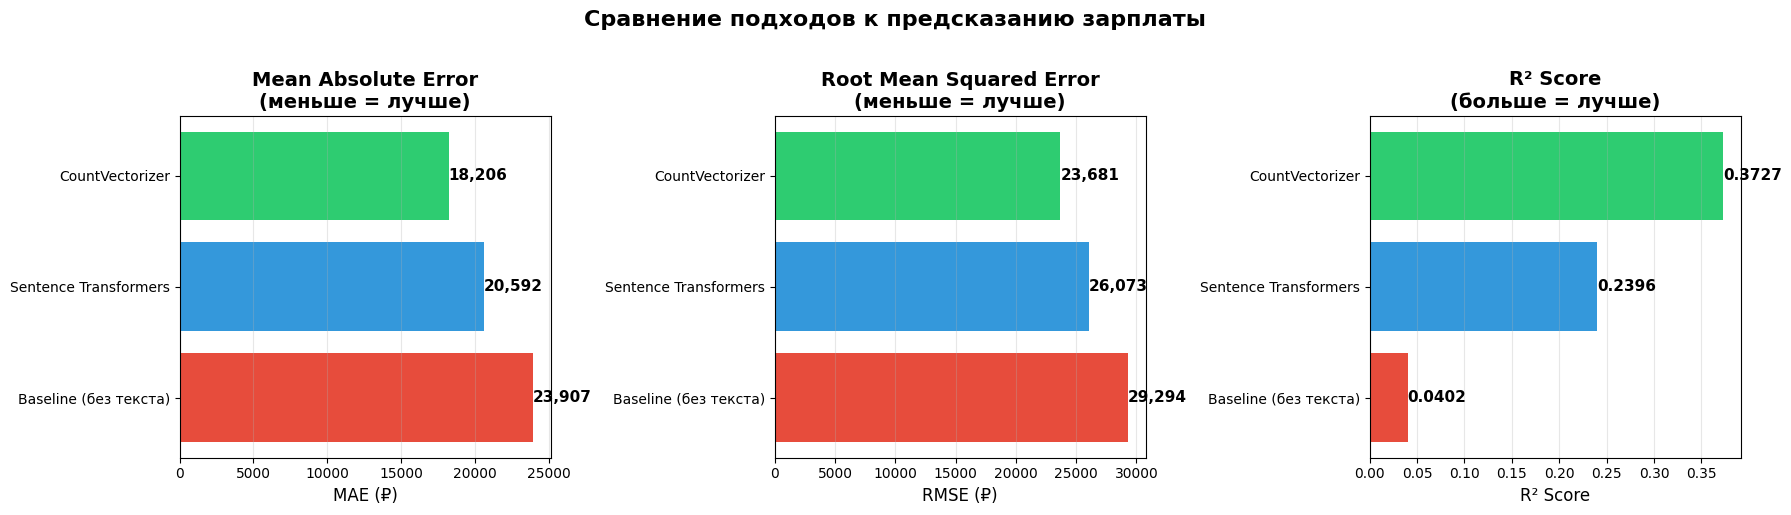

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# График 1: MAE
ax1 = axes[0]
colors_list = ['#e74c3c' if i == len(results_df) - 1 else '#3498db' if i == len(results_df) - 2 else '#2ecc71' 
               for i in range(len(results_df))]
bars1 = ax1.barh(results_df['Подход'], results_df['MAE (₽)'], color=colors_list)
ax1.set_xlabel('MAE (₽)', fontsize=12)
ax1.set_title('Mean Absolute Error\n(меньше = лучше)', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3, axis='x')
ax1.invert_yaxis()
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:,.0f}', ha='left', va='center', fontsize=11, fontweight='bold')

# График 2: RMSE
ax2 = axes[1]
bars2 = ax2.barh(results_df['Подход'], results_df['RMSE (₽)'], color=colors_list)
ax2.set_xlabel('RMSE (₽)', fontsize=12)
ax2.set_title('Root Mean Squared Error\n(меньше = лучше)', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3, axis='x')
ax2.invert_yaxis()
for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:,.0f}', ha='left', va='center', fontsize=11, fontweight='bold')

# График 3: R²
ax3 = axes[2]
bars3 = ax3.barh(results_df['Подход'], results_df['R²'], color=colors_list)
ax3.set_xlabel('R² Score', fontsize=12)
ax3.set_title('R² Score\n(больше = лучше)', fontsize=14, fontweight='bold')
ax3.grid(alpha=0.3, axis='x')
ax3.invert_yaxis()
for i, bar in enumerate(bars3):
    width = bar.get_width()
    ax3.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.4f}', ha='left', va='center', fontsize=11, fontweight='bold')

plt.suptitle('Сравнение подходов к предсказанию зарплаты', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### Визуализация 2: Предсказания vs реальные значения


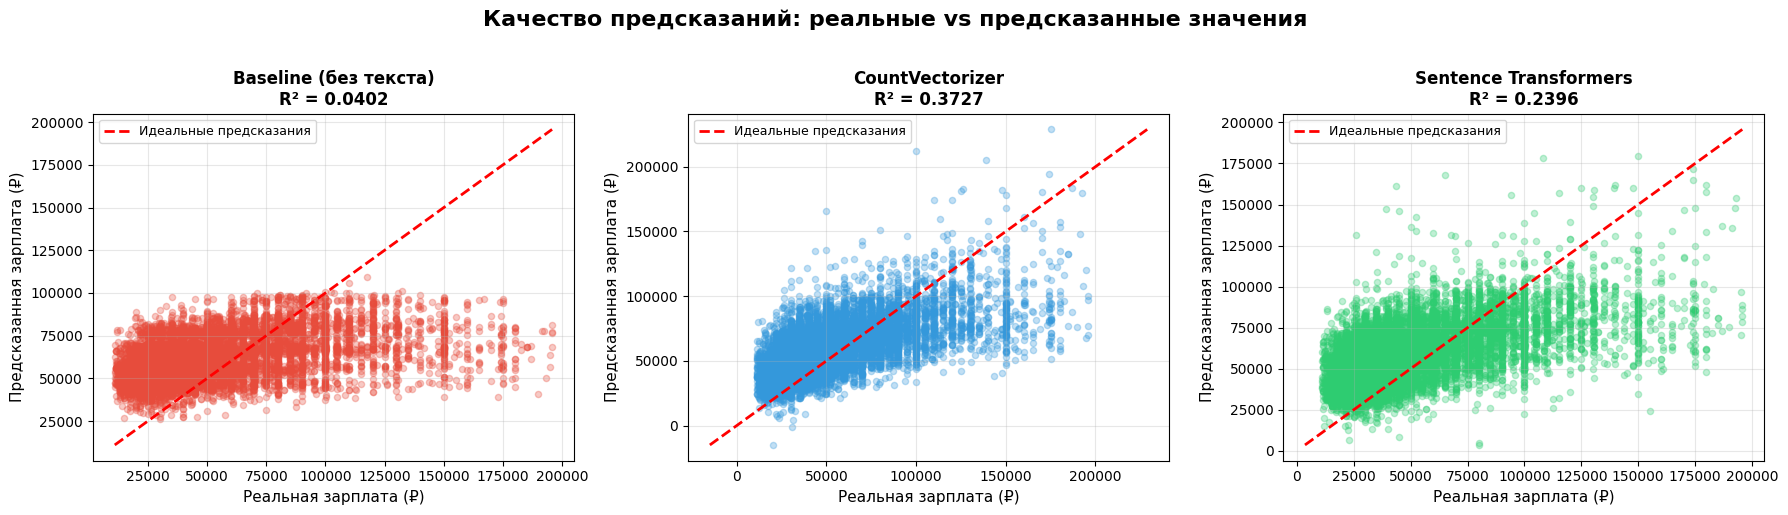

In [29]:
fig, axes = plt.subplots(1, len(results), figsize=(6*len(results), 5))

if len(results) == 1:
    axes = [axes]

colors = ['#e74c3c', '#3498db', '#2ecc71']
for idx, (name, data) in enumerate(results.items()):
    ax = axes[idx] if len(results) > 1 else axes[0]
    
    # Scatter plot
    ax.scatter(y_test, data['predictions'], alpha=0.3, s=20, color=colors[idx % len(colors)])
    
    # Идеальная линия
    min_val = min(y_test.min(), data['predictions'].min())
    max_val = max(y_test.max(), data['predictions'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Идеальные предсказания')
    
    ax.set_xlabel('Реальная зарплата (₽)', fontsize=11)
    ax.set_ylabel('Предсказанная зарплата (₽)', fontsize=11)
    ax.set_title(f'{name}\nR² = {data["R²"]:.4f}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('Качество предсказаний: реальные vs предсказанные значения', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### Визуализация 3: Распределение ошибок


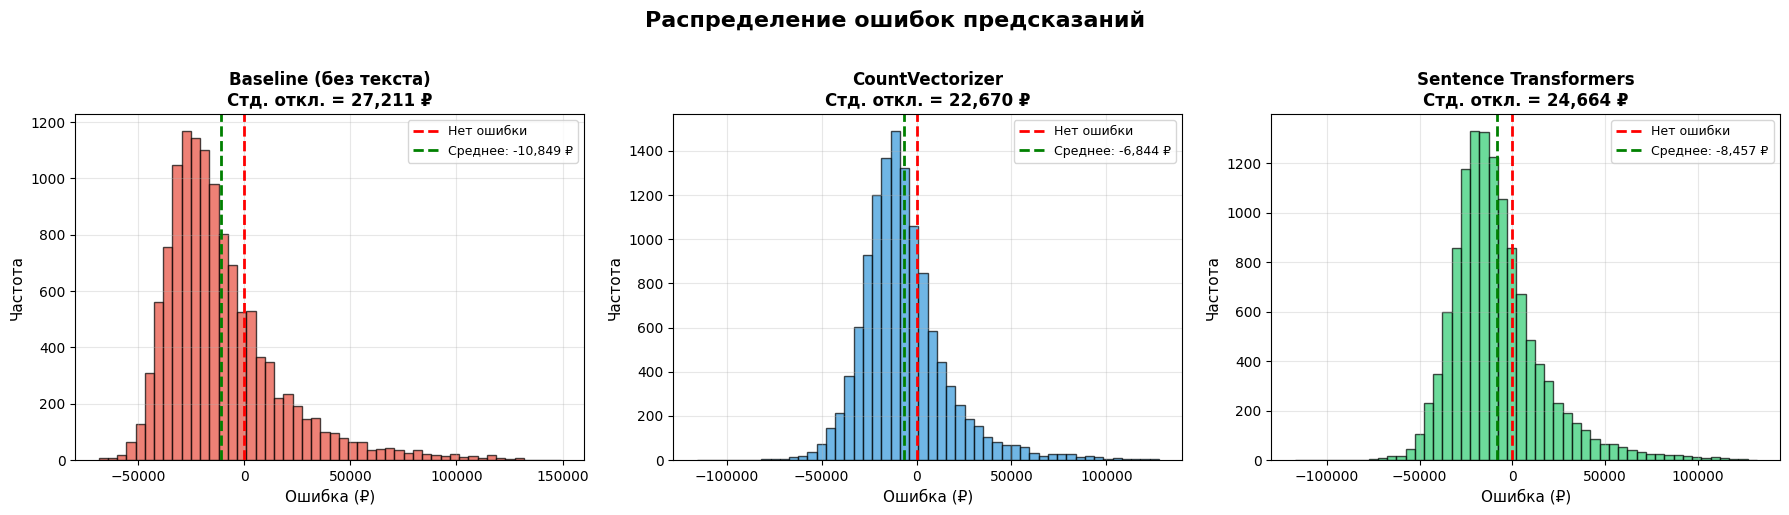

In [30]:
fig, axes = plt.subplots(1, len(results), figsize=(6*len(results), 5))

if len(results) == 1:
    axes = [axes]

colors = ['#e74c3c', '#3498db', '#2ecc71']
for idx, (name, data) in enumerate(results.items()):
    ax = axes[idx] if len(results) > 1 else axes[0]
    
    errors = y_test - data['predictions']
    
    ax.hist(errors, bins=50, edgecolor='black', alpha=0.7, color=colors[idx % len(colors)])
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Нет ошибки')
    ax.axvline(errors.mean(), color='green', linestyle='--', linewidth=2, 
               label=f'Среднее: {errors.mean():,.0f} ₽')
    
    ax.set_xlabel('Ошибка (₽)', fontsize=11)
    ax.set_ylabel('Частота', fontsize=11)
    ax.set_title(f'{name}\nСтд. откл. = {errors.std():,.0f} ₽', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('Распределение ошибок предсказаний', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 6. Выводы

### Что мы узнали:

1. **Текстовые признаки важны!** Название вакансии содержит важную информацию о зарплате

2. **CountVectorizer (Bag of Words)**:
   - ✅ Простой и быстрый
   - ✅ Легко интерпретировать (видим важные слова)
   - ❌ Не понимает синонимы и семантику
   - ❌ Большая размерность (разреженные векторы) => дольше учится классификатор

3. **Sentence Transformers (Эмбеддинги)**:
   - ✅ Понимает смысл текста
   - ✅ Компактные векторы (меньше признаков) => быстрее учится классификатор
   - ✅ Работает с синонимами
   - ❌ Сложнее интерпретировать

4. **Для данной задачи** (короткие названия вакансий) оба подхода дают улучшение по сравнению с baseline!
